# Benchmarking spike sorters


To benchmark the spike sorting algorithms, one of the easiest option is to design artifical dataset, in order to have a full control on what is created, and to have a proper "ground truth" to compare with. 

To do so, MEArec (https://github.com/alejoe91/MEArec) is a python package that can help you to generate such artificial datasets. Basically, given some templates and a probe layout, the software will generate traces that can later be used for benchmarking the sorting algorithms. In this notebook, we wont have time to cover all the possibilities offered by MEArec. While you are strongly encouraged to have a look to the API, you should have downloaded from the google drive link an already generated dataset. Feel free to ask if questions.

The comparison between different sorters can be tedious, since every one of them has a different file format. However, spikeinterface can act as a universal wrapper allowing you to launch and read the results of the sorters. Moreover, spikeinterface comes with numerous analysis functions that will allow you to quickly assess the quality of a spike sorting, and compute quality metrics with respect to the Ground Truth that have been generated

The only file needed here will be "recordings_Neuronexus-32_static.h5", that we have generated for this notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.full as si

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## Step 1 : load the MEArec ground truth recordings

In [5]:
# basedir = Path('.')
basedir = Path('/data_local/DataSpikeSorting/SI_tutorial_marseille_2023')
filename = basedir / 'Simulated_Neuronexus-32.h5'


recording, sorting_gt = si.read_mearec(filename)

In [6]:
recording

MEArecRecordingExtractor: 32 channels - 32.0kHz - 1 segments - 9,600,000 samples 
                          300.00s (5.00 minutes) - float32 dtype - 1.14 GiB
  file_path: /data_local/DataSpikeSorting/SI_tutorial_marseille_2023/Simulated_Neuronexus-32.h5

In [7]:
sorting_gt

MEArecSortingExtractor: 64 units - 1 segments - 32.0kHz
  file_path: /data_local/DataSpikeSorting/SI_tutorial_marseille_2023/Simulated_Neuronexus-32.h5

## Step 2 : open and plot the signals and the spikes from our ground truth

In [8]:
waveforms_gt = si.extract_waveforms(recording, sorting_gt,
                                    folder=None, #basedir / 'waveforms',
                                    mode="memory",
                                 ms_before=1.5, ms_after=1.5, sparse=True)


extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

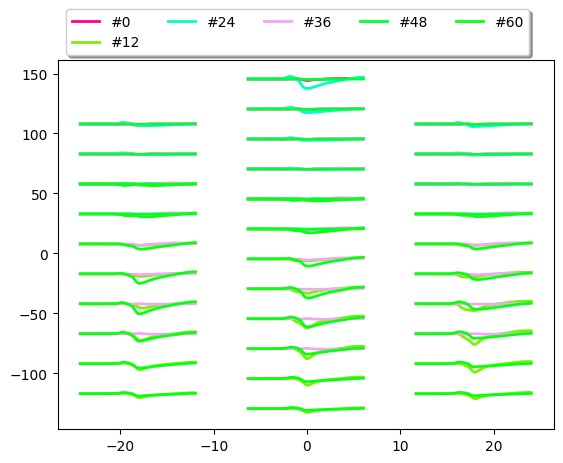

In [9]:
si.plot_unit_templates(waveforms_gt, backend='matplotlib', unit_ids=sorting_gt.unit_ids[::12], same_axis=True)

In [10]:
%matplotlib widget
si.plot_timeseries(recording, time_range=(5,5.1), backend='ipywidgets')

/home/samuel.garcia/Documents/SpikeInterface/spikeinterface/src/spikeinterface/widgets/widget_list.py:121: UserWarning: plot_timeseries() is now plot_traces()
  warnings.warn("plot_timeseries() is now plot_traces()")


AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

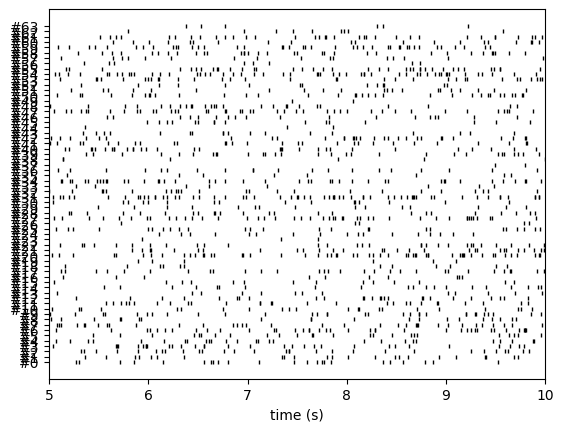

In [11]:
# We can also look at spikes
%matplotlib inline
si.plot_rasters(sorting_gt, time_range=(5,10))

In [12]:
metrics = si.compute_quality_metrics(waveforms_gt, metric_names=['firing_rate', 'snr'])
metrics

,firing_rate,snr
#0,5.396667,1.066839
#1,4.910000,1.290195
#2,5.770000,9.505666
#3,6.486667,2.747263
#4,5.086667,0.599285
...,...,...
#59,7.920000,1.935221
#60,3.556667,8.844906
#61,4.463333,0.520881
#62,1.570000,6.082588


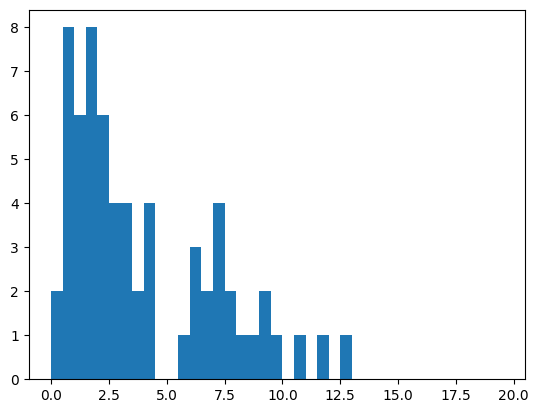

In [13]:
fig, ax = plt.subplots()
_ = ax.hist(metrics['snr'], bins=np.arange(0, 20, 0.5))

In [14]:
# only 20 units are easy too catch!!
num_big_units = np.sum(metrics['snr'] > 5)
num_big_units

20

## Step 3 : run several sorters on GT recording

In [15]:
si.Kilosort2_5Sorter.set_kilosort2_5_path('/home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5/')

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/samuel.garcia/Documents/SpikeInterface/code_sorters/Kilosort2.5


With spikeinterface, launching a spike sorting algorithm is easy. You simply need to do use the run_sorter command. Assuming we want to save every sorting into a specific folder, with a name dedicated to every sorter, we can simply do

In [16]:
sorter_names = ['kilosort2_5', 'spykingcircus2', 'tridesclous2', 'tridesclous'] #  'spykingcircus',


In [17]:
sortings = {}

for sorter_name in sorter_names:
    output_folder = basedir / f'fakedata_sorter_output_{sorter_name}'
    if output_folder.exists():
        sortings[sorter_name] = si.sorter_dict[sorter_name].get_result_from_folder(output_folder)
    else:
        sortings[sorter_name] = si.run_sorter(sorter_name, recording, output_folder, verbose=True)
# Note that the sorter list can includes 'kilosort', 'herdingspikes', ... See spikeinterface wrapper for more info

In [18]:
# sorting_tdc = sortings['tridesclous']
sorting_tdc2 = sortings['tridesclous2']
sorting_sc2 = sortings['spykingcircus2']
# sorting_sc = sortings['spykingcircus']

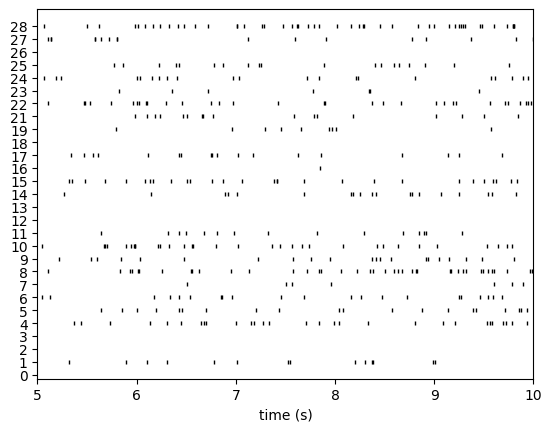

In [19]:
# We can also look at spikes
si.plot_rasters(sortings['spykingcircus2'], time_range=(5,10))

You just noticed how easy it is to run several sorters on a given recording. But what about comparisons? Now we would like to be able to quantify how good these sorters are, with respect to the ground truth units that have been created. 

## Step 4 : run comparison and plot agreement matrix for one sorter

Once we have a given spike sorting, we can always compare it to its ground-truth, via the comparison object offered by spikeinterface

In [20]:
comparisons = {}
for sorter_name in sorter_names:
    comparisons[sorter_name] = si.compare_sorter_to_ground_truth(sorting_gt, sortings[sorter_name])

In [21]:
comp_sc2 = comparisons['spykingcircus2']
# comp_sc = comparisons['spykingcircus']
# comp_tdc = comparisons['tridesclous']
comp_tdc2 = comparisons['tridesclous2']

Such a comparison object can immediatly tell us how many units are found, what are the errors rates, and much more

In [22]:
comp_sc2.agreement_scores # TO view the quality score between units

,0,1,2,3,4,5,6,7,8,9,...,18,19,21,22,23,24,25,26,27,28
#0,0.001072,0.001322,0.000000,0.001000,0.001256,0.001865,0.001057,0.000000,0.002766,0.001087,...,0.000000,0.001438,0.002364,0.002590,0.000865,0.003064,0.002567,0.000000,0.001498,0.002388
#1,0.000000,0.000471,0.000000,0.002159,0.000892,0.003160,0.011632,0.001036,0.000575,0.001530,...,0.001113,0.000515,0.001253,0.001357,0.001386,0.001215,0.001824,0.000000,0.000396,0.002691
#2,0.000505,0.000420,0.000457,0.001420,0.001601,0.001073,0.001695,0.000000,0.000535,0.002789,...,0.000486,0.000000,0.000754,0.000936,0.000825,0.001467,0.000000,0.000577,0.000718,0.002119
#3,0.000000,0.000385,0.001248,0.000429,0.000736,0.002329,0.002531,0.000832,0.002537,0.001945,...,0.001322,0.000414,0.000697,0.001170,0.001138,0.001019,0.003759,0.000000,0.002672,0.001621
#4,0.001128,0.001839,0.000000,0.000524,0.000435,0.000772,0.002919,0.000504,0.002270,0.001875,...,0.000000,0.002008,0.001635,0.002336,0.001353,0.001189,0.002227,0.000000,0.000775,0.003104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
#59,0.001526,0.000661,0.002120,0.001088,0.001591,0.001746,0.003066,0.002475,0.003205,0.002563,...,0.000741,0.000703,0.000606,0.002080,0.000978,0.001780,0.002263,0.000421,0.004096,0.003923
#60,0.000000,0.001164,0.001969,0.000690,0.001089,0.998127,0.001750,0.000000,0.001303,0.003175,...,0.001438,0.000000,0.001508,0.002758,0.000568,0.000969,0.000559,0.000000,0.000000,0.000985
#61,0.000000,0.002012,0.000556,0.000000,0.001423,0.001248,0.000781,0.000556,0.002097,0.000403,...,0.001805,0.000000,0.000884,0.003920,0.000985,0.002142,0.000485,0.000000,0.002512,0.002079
#62,0.000000,0.002676,0.000000,0.000000,0.001612,0.000000,0.001182,0.000000,0.001617,0.000000,...,0.000000,0.997877,0.000717,0.000513,0.000000,0.000680,0.000000,0.000000,0.000000,0.001154


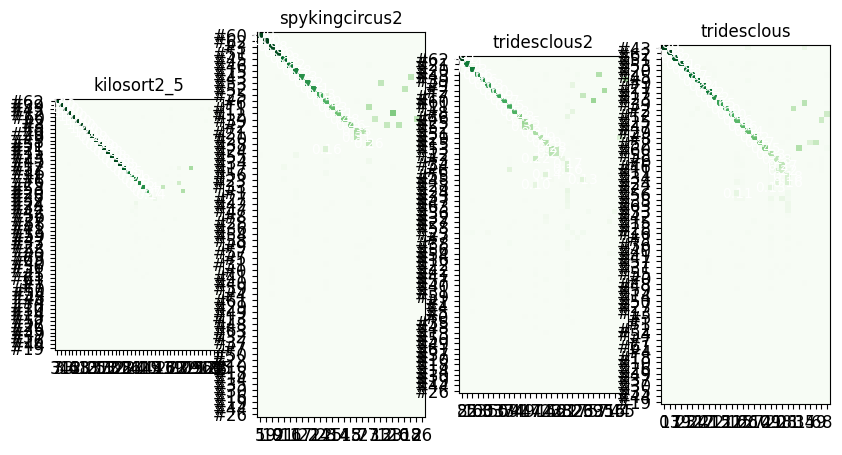

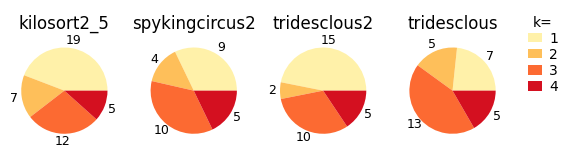

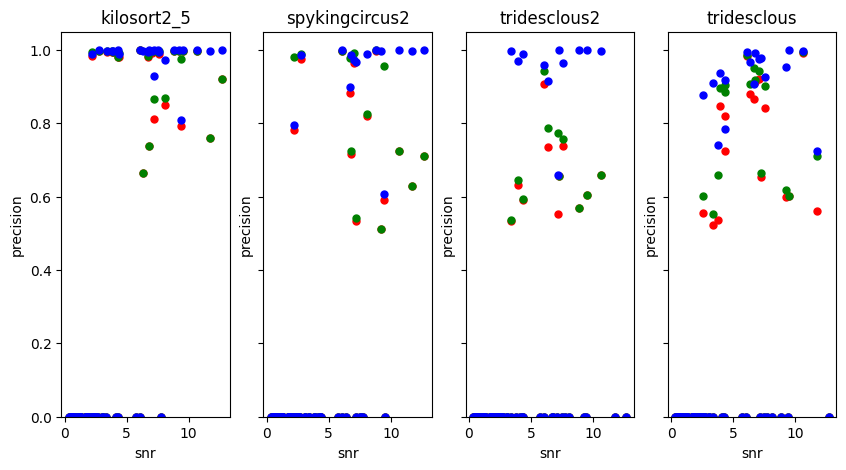

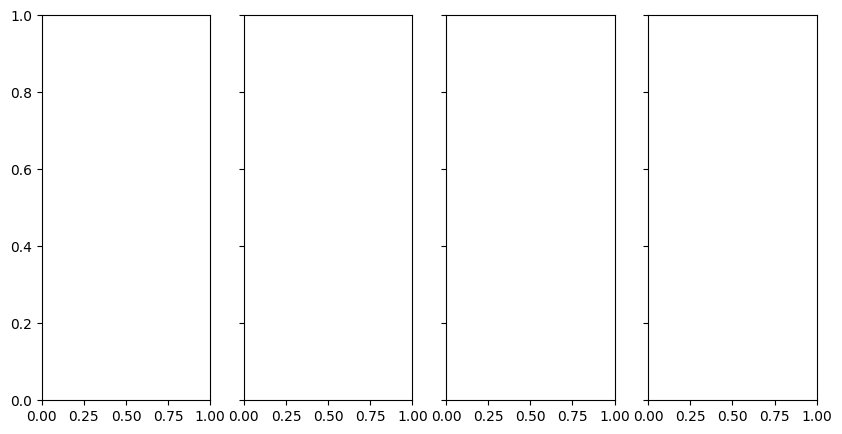

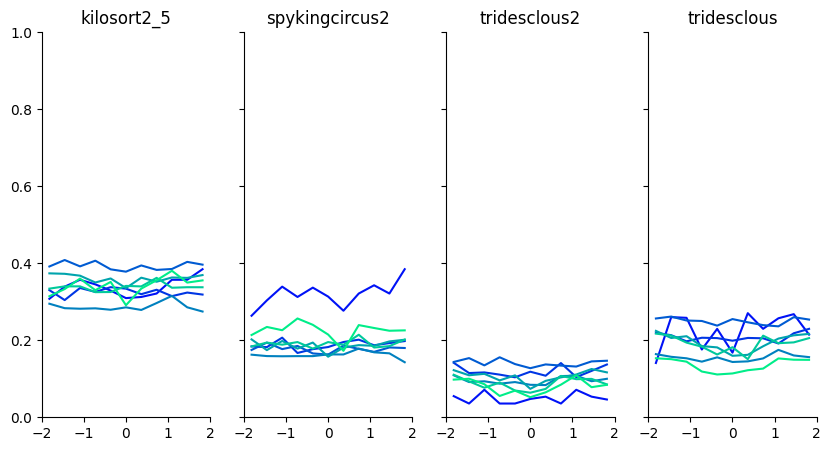

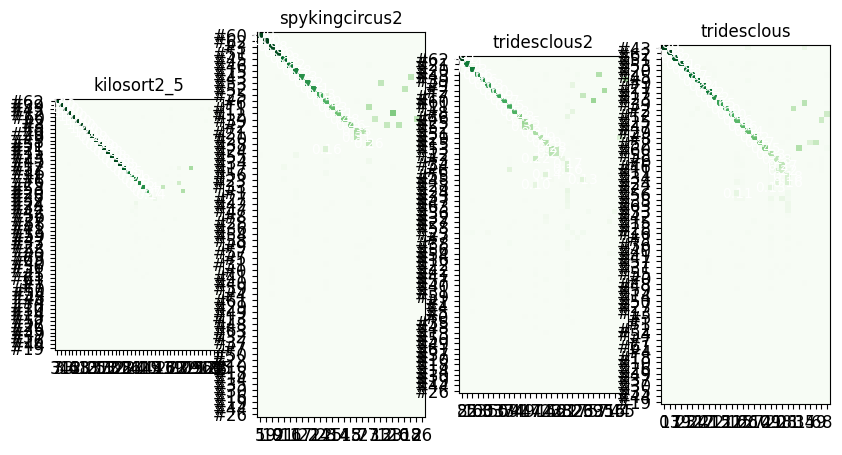

In [36]:
%matplotlib inline
n = len(sorter_names)
fig, axs = plt.subplots(ncols=n, figsize=(10, 5))

for i, sorter_name in enumerate(sorter_names):
    si.plot_agreement_matrix(comparisons[sorter_name], ax=axs[i])
    ax = axs[i]
    axs[i].set_title(sorter_name)
    axs[i].set_xlabel(None)
    axs[i].set_ylabel(None)
    
plt.show()

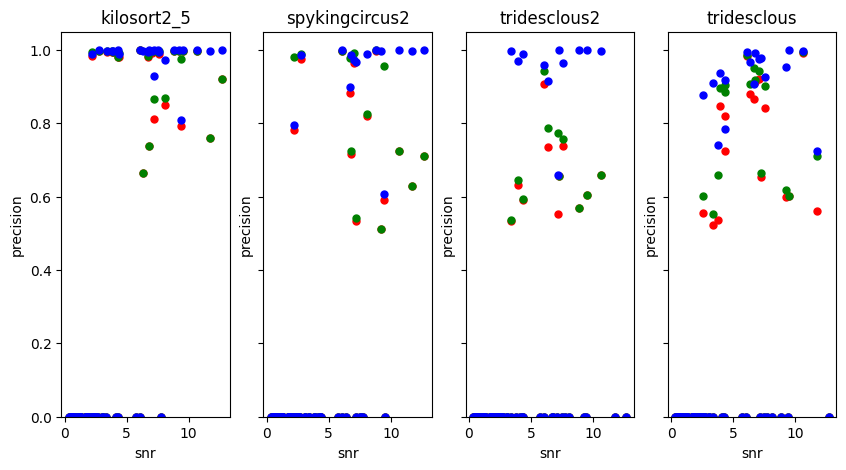

In [37]:
fig, axes = plt.subplots(1, len(sorter_names), figsize=(10, 5), sharey=True)
metrics = si.compute_quality_metrics(waveforms_gt, metric_names=['snr'], load_if_exists=True)

# for i, key in enumerate(study.cases):
for i, sorter_name in enumerate(sorter_names):
    ax = axes[i]
    ax.set_title(sorter_name)
    si.plot_sorting_performance(comparisons[sorter_name], metrics, performance_name='accuracy', metric_name='snr', ax=ax, color='r')
    si.plot_sorting_performance(comparisons[sorter_name], metrics, performance_name='recall', metric_name='snr', ax=ax, color='g')
    si.plot_sorting_performance(comparisons[sorter_name], metrics, performance_name='precision', metric_name='snr', ax=ax, color='b')        


## Step 5 : agreement between sorters

What if we have several spike sorting algorithms, and want to quickly compare each of them? The comparison could be performed on a single recording, and/or or various recordings at once, to get a more global comparison. 

Let's first start with the simple case of a single comparison, on a single recording. As said, you can easily, with spikeinterface, compare the results accross sorters. To do so, the simplest option is to launch the sorters individually, and compare the results via a so-called aggrement study

Removed node: ('spykingcircus2', 14.0)


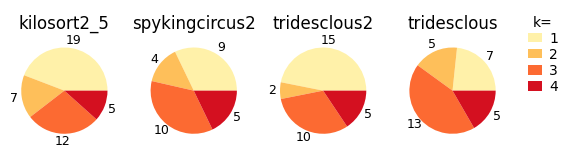

In [38]:
comp = si.compare_multiple_sorters(list(sortings.values()), sorter_names)
si.plot_multicomp_agreement_by_sorter(comp)

## Step 6 : Challenging the collisions

In [ ]:
collisions_comparisons = {}
for i, sorter_name in enumerate(sorter_names):
    collisions_comparisons[sorter_name] = si.CollisionGTComparison(sorting_gt, sortings[sorter_name])


In [ ]:
templates = waveforms_gt.get_all_templates()

In [ ]:
n = len(sorter_names)
fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(10, 5), sharey=True)

for i, sorter_name in enumerate(sorter_names):
    si.plot_comparison_collision_by_similarity(collisions_comparisons[sorter_name], templates, mode='lines', 
                                               good_only=False, ax=axes[i])
    axes[i].set_title(sorter_name)
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)
